In [1]:
import numpy as np
import sys
import os
import fitsio as fi
import pylab as plt
import numpy.fft as npf
tidal_tensor = {}

In [17]:
# set up a toy model box, populated with random points 
np.random.seed(9876)
npart = int(4e7)
box_size_mpc = 300
xp = np.random.rand(npart)*box_size_mpc
yp = np.random.rand(npart)*box_size_mpc
zp = np.random.rand(npart)*box_size_mpc

nx = int(128) # pixel resolution
n0 = int(nx/2.) # mid point

In [18]:
# turn the particle posittions into a density field
ptcl_coords=np.array([xp,yp,zp]).T
W = np.ones(npart)

density,edges = np.histogramdd(ptcl_coords, nx, range=[[0,box_size_mpc],[0,box_size_mpc],[0,box_size_mpc]], weights=W)



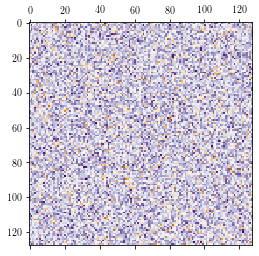

In [19]:
# plot it
plt.matshow(np.log10(density[n0,:,:]), cmap='PuOr')

In [20]:
# overdensity field
K = np.mean(density)
d = density/K -1 

Vpix = (300/nx)**3 # volume of a pixel in Mpc^3


In [21]:
# set up some arrays for the tidal tensor
k  = npf.fftfreq(nx)[np.mgrid[0:nx,0:nx,0:nx]]
tidal_tensor[nx] = np.zeros((nx,nx,nx,3,3),dtype=np.float32)

# FFT the box
fft_dens = npf.fftn(d) 

# now compute the tidal tensor

for i in range(3):
    for j in range(3):
        print(i,j)
        # k[i], k[j] are 3D matrices
        temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2 + k[2]**2)
        
        # subtract off the trace...
        if (i==j):
            temp -= 1./3 * fft_dens
        
        temp[0,0,0] = 0
        tidal_tensor[nx][:,:,:,i,j] = npf.ifftn(temp).real

0 0


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


In [22]:
# repeat all of the above with a couple of different pixel scales
for nx in [16,32,64]:
    print('doing nx=%d'%nx)
    density,edges = np.histogramdd(ptcl_coords, nx, range=[[0,box_size_mpc],[0,box_size_mpc],[0,box_size_mpc]], weights=W)
    
    # overdensity field
    K = np.mean(density)
    d = density/K -1
    
    # set up some arrays for the tidal tensor
    k  = npf.fftfreq(nx)[np.mgrid[0:nx,0:nx,0:nx]]
    tidal_tensor[nx] = np.zeros((nx,nx,nx,3,3),dtype=np.float32)
    
    # FFT the box
    fft_dens = npf.fftn(d) 
    
    # now compute the tidal tensor
    for i in range(3):
        for j in range(3):
            temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2 + k[2]**2)
            
            # subtract off the trace...
            if (i==j):
                temp -= 1./3 * fft_dens
                
            temp[0,0,0] = 0
            tidal_tensor[nx][:,:,:,i,j] = npf.ifftn(temp).real
    
    
    



doing nx=16


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


doing nx=32
doing nx=64


Text(0, 0.5, '$S^{ii}(R)$')

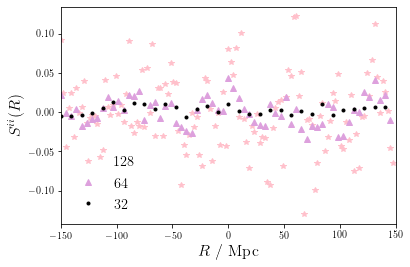

In [23]:
#scatter plot the result

L1 = 300./float(128)
L2 = 300./float(64)
L3 = 300./float(256)
L4 = 300./float(32)
x1 = np.arange(-128/2, 128/2,1)*L1
x2 = np.arange(-64/2, 64/2,1)*L2
x3 = np.arange(-256/2, 256/2,1)*L3
x4 = np.arange(-32/2, 32/2,1)*L4


plt.plot(x1,tidal_tensor[128][64,64,:,0,0],'*',color='pink', label='$128$')
plt.plot(x2,tidal_tensor[64][32,32,:,0,0],'^',color='plum', label='$64$')
plt.plot(x4,tidal_tensor[32][16,16,:,0,0],'.',color='k', label='$32$')

plt.xlim(-150,150)
plt.legend()
plt.xlabel('$R$ / Mpc', fontsize=16)
plt.ylabel('$S^{ii}(R)$', fontsize=16)

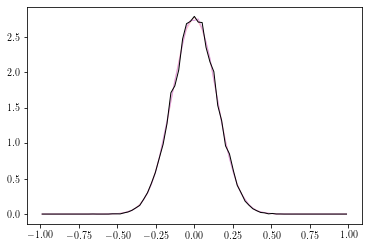

In [24]:
elem=0
normed=True
F=2.85 # <---------- BEWARE: empirical scaling
H1,bins1 = np.histogram(tidal_tensor[128][:,:,:,:,:][::10]*F, bins=np.linspace(-1,1,80), density=normed)
H2,bins2 = np.histogram(tidal_tensor[64][:,:,:,:,:][::10]*F*F, bins=np.linspace(-1,1,80), density=normed)
H3,bins3 = np.histogram(tidal_tensor[32][:,:,:,:,:][::10]*F*F*F, bins=np.linspace(-1,1,80), density=normed)


xbins = (bins1[:-1]+bins1[1:])/2
plt.plot(xbins,H1,color='pink')
plt.plot(xbins,H2,color='plum')
plt.plot(xbins,H3,color='k')

Text(0, 0.5, 'variance')

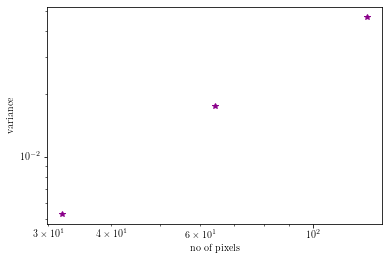

In [25]:
plt.plot([32,64,128],[tidal_tensor[32][16,16,:,elem,elem].std(), tidal_tensor[64][32,32,:,elem,elem].std(), tidal_tensor[128][64,64,:,elem,elem].std()], '*', color='darkmagenta')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('no of pixels')
plt.ylabel('variance')